In [2]:
import json
import pandas
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import interp1d

/var/folders/6y/1gfy1yb96_59763zctgly20h0000gn/T/ipykernel_75056/1061289714.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas


In [3]:
def load_lf_data_1() -> pd.DataFrame:
    """Note: the data sources are quite messy, e.g. this .npz function was sent to me on slack.
    I believe that it contains the same data as the other LF data loaded below in
    load_lf_data_2
    """
    with open('processed_dataset_unnormalised.npz', 'rb') as f:
        data = np.load(f)
        X = data['X_train']
        y = data['Y_train']
        
    y_scaled = MinMaxScaler().fit_transform(y)
    ignition = (y_scaled[:, 2] > 0.5).astype(int)
    
    df = pd.DataFrame(X)
    df['ignition'] = ignition
    df['y0'] = y_scaled[:, 0]
    df['y1'] = y_scaled[:, 1]
    df['y2'] = y_scaled[:, 2]
    
    df.columns = ['radial position', 'streamwise position', 'lobe ratio', 'energy', 'delay time', 'ignition', 'y0', 'y1', 'y2']
    
    df['fidelity'] = 'low fidelity'
    
    # I believe we need to multiply by a factor of 3.175 to get the correct spatial positions
    df['radial position'] = df['radial position'] * 3.175
    df['streamwise position'] = df['streamwise position'] * 3.175
        
    return df


def load_lf_data_2() -> pd.DataFrame:
    with open('lf_data_xi_1.json', 'r') as f:
        xi = json.load(f)
        
    with open('lf_data_pressure_1.json', 'r') as f:
        pressure = json.load(f)
        
    xi = np.array([v for v in xi.values()])  # List of list of xi values
    
    interpolated_pressures = []
    
    for v in pressure.values():
        x = np.linspace(0, 1, len(v[0]))
        f = interp1d(x, v[0])
        xnew = np.linspace(0, 1, 100)
        ynew = f(xnew)
        interpolated_pressures.append(ynew)
        
    pressure = np.array(interpolated_pressures)
    pressure_normalised = MinMaxScaler().fit_transform(pressure)
    
    ignition = (pressure_normalised[:, -1] > 0.25).astype(int)
    
    df = pd.DataFrame(xi)
    df['ignition'] = ignition
    df['p_final'] = pressure_normalised[:, -1]
    df['p_mean'] = pressure_normalised.mean(axis=1)
    df['p_max'] = pressure_normalised.max(axis=1)
    
    
    
    return df


df1 = load_lf_data_1()
        
    
df1

,radial position,streamwise position,lobe ratio,energy,delay time,ignition,y0,y1,y2,fidelity
0,8.602112,19.345540,1.702112,22.647896,7.5,0,0.000000,0.000000,0.007836,low fidelity
1,8.322416,19.370536,1.428762,25.077673,22.5,1,0.352908,0.620496,0.867892,low fidelity
2,8.321865,19.404088,1.682927,22.818428,25.0,1,0.582414,0.581954,0.915427,low fidelity
3,8.751034,19.334651,1.281278,26.388637,0.0,0,0.000000,0.000000,0.001959,low fidelity
4,8.562796,19.406642,1.437238,25.002329,17.5,1,0.621354,0.696968,0.897170,low fidelity
...,...,...,...,...,...,...,...,...,...,...
143,8.838566,19.309762,1.603213,24.635202,10.0,0,0.000000,0.000000,0.009262,low fidelity
144,8.637897,19.327973,1.583362,24.048517,25.0,0,0.000000,0.000000,0.017780,low fidelity
145,8.529608,19.358856,1.755174,23.159893,5.0,0,0.000000,0.000000,0.000153,low fidelity
146,8.198862,19.305296,1.277191,28.498694,0.0,0,0.000000,0.000000,0.002024,low fidelity


In [4]:
def load_experimental_data() -> pd.DataFrame:
    df = pd.read_csv('gp_exp_dataset.csv', header=0)
    df.columns = ['test_num', 'ignition', 'radial position', 'streamwise position', 'energy']
    
    df['fidelity'] = 'experiment'
    
    return df

df2 = load_experimental_data()

In [5]:
df2

,test_num,ignition,radial position,streamwise position,energy,fidelity
0,138,1,0.692802,7.059176,14.226864,experiment
1,139,1,0.422341,7.283198,14.768996,experiment
2,140,1,0.533436,6.790270,17.351047,experiment
3,142,1,0.604407,6.969960,13.306910,experiment
4,143,1,0.277857,7.540025,13.711392,experiment
...,...,...,...,...,...,...
188,335,1,0.810648,20.370689,28.359636,experiment
189,336,1,0.474452,20.441054,27.360087,experiment
190,337,1,0.624706,20.591433,28.069218,experiment
191,338,1,0.534999,21.128307,31.727890,experiment


In [6]:
df_combined = pd.concat([df1, df2], axis=0, ignore_index=True)
df_combined

,radial position,streamwise position,lobe ratio,energy,delay time,ignition,y0,y1,y2,fidelity,test_num
0,8.602112,19.345540,1.702112,22.647896,7.5,0,0.000000,0.000000,0.007836,low fidelity,NaN
1,8.322416,19.370536,1.428762,25.077673,22.5,1,0.352908,0.620496,0.867892,low fidelity,NaN
2,8.321865,19.404088,1.682927,22.818428,25.0,1,0.582414,0.581954,0.915427,low fidelity,NaN
3,8.751034,19.334651,1.281278,26.388637,0.0,0,0.000000,0.000000,0.001959,low fidelity,NaN
4,8.562796,19.406642,1.437238,25.002329,17.5,1,0.621354,0.696968,0.897170,low fidelity,NaN
...,...,...,...,...,...,...,...,...,...,...,...
336,0.810648,20.370689,NaN,28.359636,NaN,1,NaN,NaN,NaN,experiment,335.0
337,0.474452,20.441054,NaN,27.360087,NaN,1,NaN,NaN,NaN,experiment,336.0
338,0.624706,20.591433,NaN,28.069218,NaN,1,NaN,NaN,NaN,experiment,337.0
339,0.534999,21.128307,NaN,31.727890,NaN,1,NaN,NaN,NaN,experiment,338.0


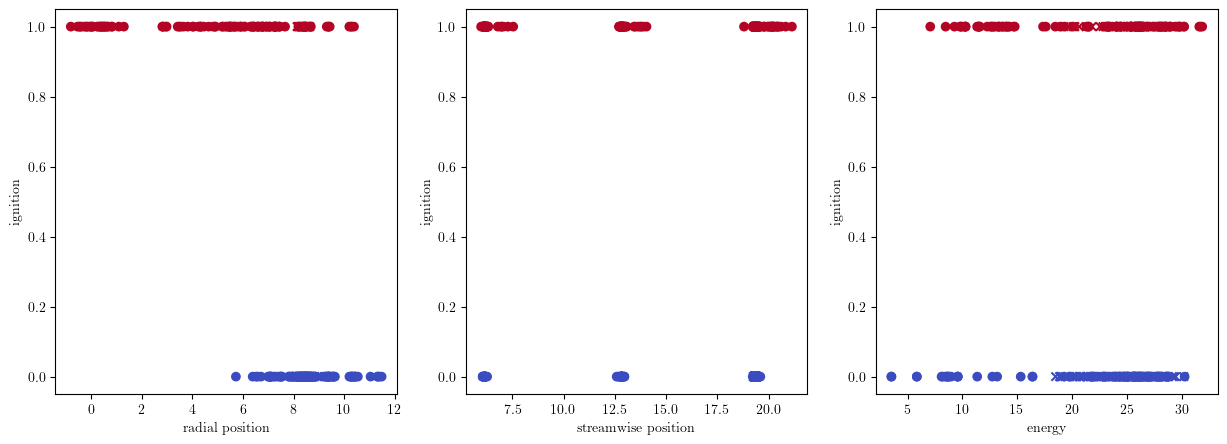

In [7]:
def visualise_df_combined(df: pd.DataFrame):
    # Compare experimental and low fidelity data
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    for i, col in enumerate(['radial position', 'streamwise position', 'energy']):
        exp_df = df[df['fidelity'] == 'experiment']
        ax[i].scatter(exp_df[col], exp_df['ignition'], c=exp_df['ignition'], cmap='coolwarm', marker='o')
        
        lf_df = df[df['fidelity'] == 'low fidelity']
        ax[i].scatter(lf_df[col], lf_df['ignition'], c=lf_df['ignition'], cmap='coolwarm', marker='x')
        
        ax[i].set_xlabel(col)
        ax[i].set_ylabel('ignition')
        
    plt.show()
    
visualise_df_combined(df_combined)

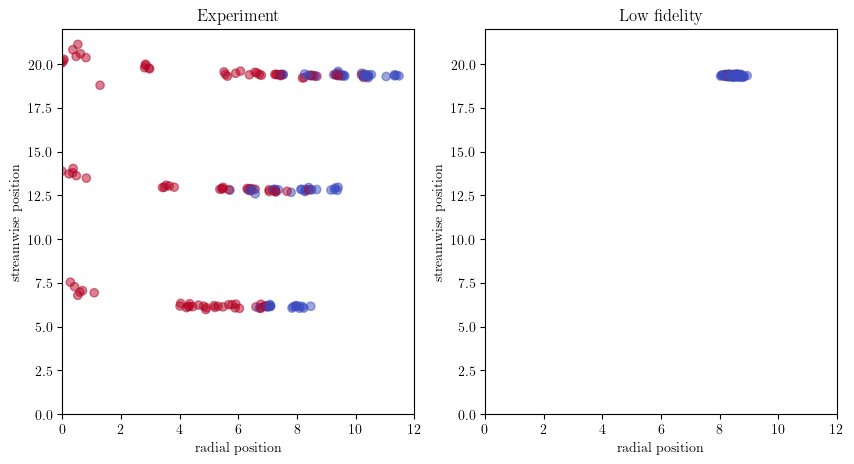

In [8]:
def plot_positions_and_ignition(df: pd.DataFrame):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    df_exp = df[df['fidelity'] == 'experiment']
    ax[0].scatter(df_exp['radial position'], df_exp['streamwise position'], c=df_exp['ignition'], cmap='coolwarm', marker='o', alpha=0.5)
    ax[0].set_xlabel('radial position')
    ax[0].set_ylabel('streamwise position')
    ax[0].set_xlim(0, 12)
    ax[0].set_ylim(0, 22)
    ax[0].set_title('Experiment')
    
    df_lf = df[df['fidelity'] == 'low fidelity']
    ax[1].scatter(df_lf['radial position'], df_lf['streamwise position'], c=df_lf['ignition'], cmap='coolwarm', alpha=0.5)
    ax[1].set_xlabel('radial position')
    ax[1].set_ylabel('streamwise position')
    ax[1].set_xlim(0, 12)
    ax[1].set_ylim(0, 22)
    ax[1].set_title('Low fidelity')
    
    plt.show()
    
plot_positions_and_ignition(df_combined)

# Dimensionality references

See message from Tony

def my_params():
    pRef = 101325.0 #pres
    Tref = 300.00   #temp
    tRef = 1.1375e-5 #time
    Lref = 0.003175 #length reg
    uRef = 2.792e+02 #velocty scale
    rhoRef = 1.2998553074969466
    eRef   = 77950.983786892 #J/m^3
    
chamber length = 111.3mm
chamber diameter = 50.8mm

In [43]:
xs, ys, zs = np.meshgrid(np.linspace(0, 12, 10), np.linspace(0, 22, 10), np.linspace(15, 25, 10))
fs = xs - 4 - 0.2 * ys - 0.1 * (zs - 20) + np.random.normal(0, 1, xs.shape)
ignition = (fs < 0).astype(int)

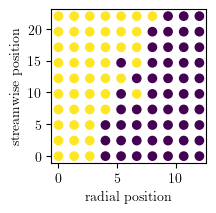

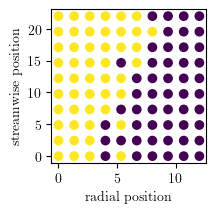

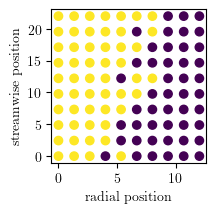

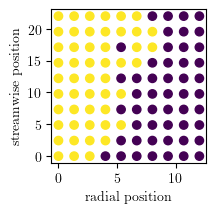

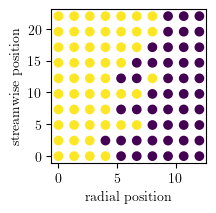

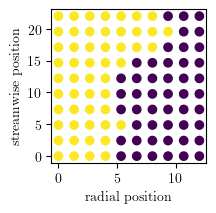

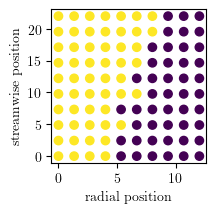

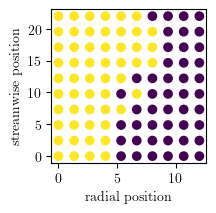

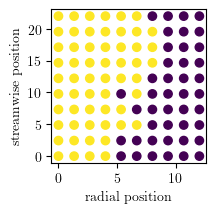

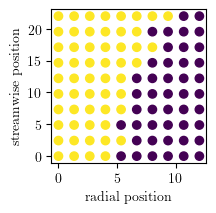

In [44]:
for i in range(10):
    fig = plt.figure(figsize=(2, 2))
    ax = fig.add_subplot(111)
    ax.scatter(xs[:, :, i], ys[:, :, i], c=ignition[:, :, i])
    ax.set_xlabel('radial position')
    ax.set_ylabel('streamwise position')
    plt.show()
    

In [46]:
# Add the simulated LF data to the dataframe

df_sim = pd.DataFrame({
    'radial position': xs.flatten(),
    'streamwise position': ys.flatten(),
    'energy': zs.flatten(),
    'ignition': ignition.flatten(),
    'fidelity': 'simulated low fidelity'
})

df_combined = pd.concat([df_combined, df_sim], axis=0, ignore_index=True)

In [48]:
df_combined

,radial position,streamwise position,lobe ratio,energy,delay time,ignition,y0,y1,y2,fidelity,test_num
0,8.602112,19.345540,1.702112,22.647896,7.5,0,0.000000,0.000000,0.007836,low fidelity,NaN
1,8.322416,19.370536,1.428762,25.077673,22.5,1,0.352908,0.620496,0.867892,low fidelity,NaN
2,8.321865,19.404088,1.682927,22.818428,25.0,1,0.582414,0.581954,0.915427,low fidelity,NaN
3,8.751034,19.334651,1.281278,26.388637,0.0,0,0.000000,0.000000,0.001959,low fidelity,NaN
4,8.562796,19.406642,1.437238,25.002329,17.5,1,0.621354,0.696968,0.897170,low fidelity,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1336,12.000000,22.000000,NaN,20.555556,NaN,0,NaN,NaN,NaN,simulated low fidelity,NaN
1337,12.000000,22.000000,NaN,21.666667,NaN,0,NaN,NaN,NaN,simulated low fidelity,NaN
1338,12.000000,22.000000,NaN,22.777778,NaN,0,NaN,NaN,NaN,simulated low fidelity,NaN
1339,12.000000,22.000000,NaN,23.888889,NaN,0,NaN,NaN,NaN,simulated low fidelity,NaN


In [49]:
df_combined.to_csv('multi_fidelity_ignition_dataset.csv', index=False)